# Circuit partitioning Walkthrough

This is a brief intro to the contents of the repository, showing a basic workflow for partitioning a quantum circuit across multiple QPUs.

The partitioning has a number of phases, some of which can be modified or removed in a modular fashion.

We are given a circuit and quantum network information by the user and we want to return a partitioned circuit which is compatible with the network, and minimal in terms of the required entanglement.

Typically we have the phases:

1. Transpilation

The circuit is transpiled into a particular gate set. We recommend the $[ U(\theta, \phi, \lambda), CP(\theta)]$ gateset, since , which is used by default.

2. Graph conversion

The circuit is converted into a "temporal graph" representing qubit interactions over time.

3. Gate grouping (optional)

Edges on the graph are merged into hyper-edges based on their compatibility for gate teleportation. 

3. Coarsening (optional) 

The graph is coarsened into a graph which is smaller and easier to optimise.

4. Partitioning and refinment 

The graph is partitioned using the FM algorithm. If the graph has been coarsened, the partitioning is refined at each level until the original graph is recovered.

6. Circuit extraction

A quantum circuit is extracted, containing all the new information for qubit and gate teleportation.


## Transpilation

We begin by defining a circuit and using the built in qiskit transpiler to put it into the (u,cp) gate-set.

In [10]:
from qiskit.circuit.library import QFT
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from qiskit import transpile
from QASMBench.interface.qiskit import QASMBenchmark
from disqco.graphs.quantum_network import QuantumNetwork


num_qubits = 16

circuit = cp_fraction(num_qubits, num_qubits, fraction=0.5)

# circuit = QFT(num_qubits, do_swaps=False)

num_partitions = 4 # Define the number of partitions or QPUs you will distribute over
depth = circuit.depth() + 2

qpu_size = num_qubits // num_partitions + 1 # Define the number of qubits per QPU. For simplicity, we divide qubits evenly and add one additional space to each for teleportation (an extra space is needed for the teleportation qubit so the algorithmr requires it!)
qpu_sizes = [qpu_size] * num_partitions # Store the number of qubits per QPU in a list

# Create a quantum network with the specified number of qubits and partitions

# If we do not specificy the connectivity, we have all-to-all by default.

quantum_network = QuantumNetwork(qpu_sizes)



basis_gates = ['u', 'cp']

# Transpile the circuit to the basis gates
circuit = transpile(circuit, basis_gates=basis_gates)

print(f'Number of qubits in circuit {circuit.num_qubits}')
print(f'Circuit depth: {circuit.depth()}')

Number of qubits in circuit 16
Circuit depth: 16


# Graph conversion

We now convert the circuit to the GCP Hypergraph using a number of predefined functions which can be found in the src code.

There is an optional parameter in the 'map_circuit_to_hypergraph' function called 'group_gates'. If this is set to false, then we get a regular graph with state edges connecting qubit nodes at successive time steps, and state edges for each two-qubit gate. If group_gates is set to true, then a pass is applied which merges some of these gate edges into hyper-edges. This makes the graph structure a bit more complex, so avoid it for now. We can tackle that later.

We will also set the 'assignment' which is our problem variable. It's a matrix of dimension $depth \times num\_qubits$. Assignment[t][q] indicates the partition qubit $q$ is assigned to at time $t$. This corresponds to node $(q,t)$. The initial assignment just maps qubits in a greedy fashion, squeezing qubits onto the first QPU until its full then moving to the next. The assignment at $t=0$ is then used for the full depth.

In [11]:
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from disqco.parti.FM.FM_methods import set_initial_partitions

depth = circuit.depth() # Get the depth of the circuit

graph = QuantumCircuitHyperGraph(circuit, group_gates=True, anti_diag=True, map_circuit=True)

assignment = set_initial_partitions(quantum_network, num_qubits, depth, num_partitions)
 
for t in range(depth):
    for q in range(num_qubits):
        print(f'Qubit {q} is assigned to partition {assignment[t][q]} at time {t}')


Qubit 0 is assigned to partition 3 at time 0
Qubit 1 is assigned to partition 3 at time 0
Qubit 2 is assigned to partition 3 at time 0
Qubit 3 is assigned to partition 3 at time 0
Qubit 4 is assigned to partition 3 at time 0
Qubit 5 is assigned to partition 2 at time 0
Qubit 6 is assigned to partition 2 at time 0
Qubit 7 is assigned to partition 2 at time 0
Qubit 8 is assigned to partition 2 at time 0
Qubit 9 is assigned to partition 2 at time 0
Qubit 10 is assigned to partition 1 at time 0
Qubit 11 is assigned to partition 1 at time 0
Qubit 12 is assigned to partition 1 at time 0
Qubit 13 is assigned to partition 1 at time 0
Qubit 14 is assigned to partition 1 at time 0
Qubit 15 is assigned to partition 0 at time 0
Qubit 0 is assigned to partition 3 at time 1
Qubit 1 is assigned to partition 3 at time 1
Qubit 2 is assigned to partition 3 at time 1
Qubit 3 is assigned to partition 3 at time 1
Qubit 4 is assigned to partition 3 at time 1
Qubit 5 is assigned to partition 2 at time 1
Qubi

If you want to look at the graph, you can use the following code to draw it. It's just something that's been thrown together so doesn't work very well and you have to play around with the scale but it can be useful to see what's going on.

The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz


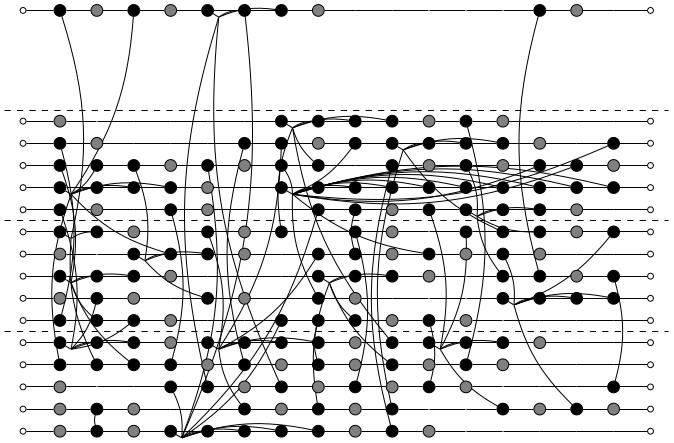

In [12]:
from disqco.drawing.tikz_drawing import draw_graph_tikz

%load_ext jupyter_tikz

fig = draw_graph_tikz(graph, assignment, qpu_sizes)
display(fig)

## Partitioning

First we consider standard partitioning with the FM algorithm (i.e. no Coarsening).

In [13]:
from disqco.parti.FM.FM_main import run_FM

node_counts = len(graph.nodes)

move_limit = node_counts * 0.125

final_cost, final_assignment, cost_list = run_FM(
    graph,
    assignment,
    qpu_sizes
)

print(f'Final cost: {final_cost}')


Final cost: 25


If you want you can use the drawing tool to see what the new solution looks like, where the nodes are dragged around to match the assignment. The assignment variable will have to be replaced with final_assignment now! If it's working properly you should see two (or however many partitions you have) sub-graphs which are connected only by the non-local/cutting edges. You can count them to make sure it corresponds to the final cost (although this gets messy for big graphs and when hyper-edge are introduced)

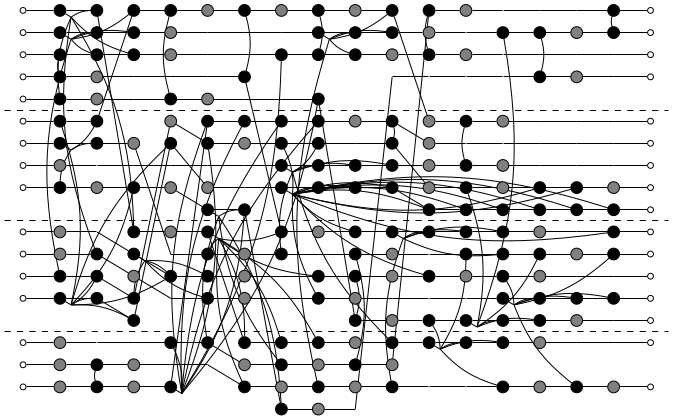

In [14]:
fig = draw_graph_tikz(graph, final_assignment, qpu_sizes)
display(fig)

In most cases, we can get a better result and a quicker solution using some coarsening. In this example, we use a recursive coarsening method, which is the most effective from the paper. The coarsening and partitioning is all taken care of by the "MLFM_recursive" function. See the coarsening notebook see how it works and to explore other methods.

In [15]:
from disqco.parti.FM.multilevel_FM import MLFM_recursive


final_cost_MLFMR, final_assignment_MLFMR, cost_list_MLFMR = MLFM_recursive(graph,
                                        assignment,  
                                        qpu_sizes)


print(f'Final cost: {final_cost_MLFMR}')

if final_cost_MLFMR < final_cost:
    print("Final cost is smaller than FM cost, using MLFM assignment")
    best_assignment = final_assignment_MLFMR


Final cost: 22
Final cost is smaller than FM cost, using MLFM assignment


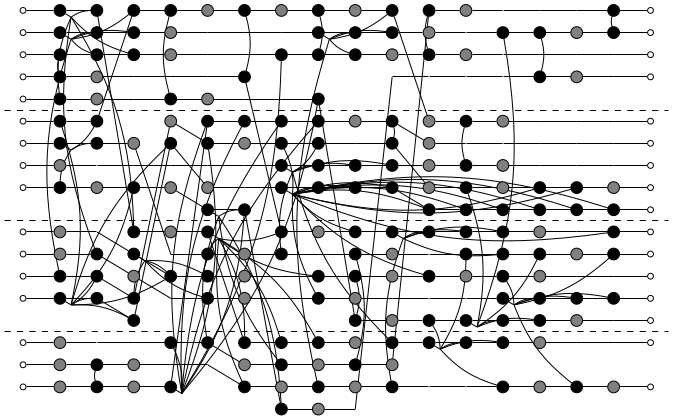

In [16]:
fig = draw_graph_tikz(graph, final_assignment, qpu_sizes)
display(fig)

# Circuit extraction



In [17]:
from disqco.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor

extractor = PartitionedCircuitExtractor(graph=graph, 
                                        partition_assignment=best_assignment, 
                                        qpu_info=qpu_sizes, 
                                        comm_info=[2]*num_partitions)

final_circuit = extractor.extract_partitioned_circuit()

In [18]:
final_circuit = transpile(final_circuit, basis_gates=basis_gates + ['EPR'])

print("Number of EPR pairs in partitioned circuit: ", final_circuit.count_ops()['EPR'])

Number of EPR pairs in partitioned circuit:  22


In [19]:
from disqco.circuit_extraction.verification import run_sampler, plot

measured_circuit = circuit.copy()
measured_circuit.measure_all()

data_circ = run_sampler(measured_circuit, shots=10000)

plot(data_circ)

Too many qubits
No data to plot


In [20]:
data_circ_part = run_sampler(final_circuit, shots=10000)

plot(data_circ_part)

Too many qubits
No data to plot


In [21]:
final_circuit.draw(output='mpl', style = 'bw', fold=100) # Draw the circuit

See circuit extraction notebook for more!